In [384]:
# Dataframes
import pandas as pd

# Math
import numpy as np
from math import e

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Prepping data for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import accuracy_score

# For interactive confusion matrix
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive, FloatSlider

# For tuning hyperparameters
from pprint import pprint
from sklearn.model_selection import GridSearchCV

In [372]:
# Import data
df_train = pd.read_csv('df_train_noDrop.csv')
df_test = pd.read_csv('df_test_noDrop.csv')

In [373]:
# Drop unnecessary columns
df_train.drop(columns='Unnamed: 0', inplace = True)
df_test.drop(columns='Unnamed: 0', inplace = True)

df_train.drop(columns='Unnamed: 0.1', inplace = True)
df_test.drop(columns='Unnamed: 0.1', inplace = True)

In [374]:
#Get rid of population outliers
df_train = df_train[~(df_train.population > 12000)]
df_test = df_test[~(df_test.population > 12000)]

In [375]:
# 1 represents non-functional or needs repair water pumps. 0 represents functional water pumps.
def change_target(row):
    if row['status_group'] == 3:
        return 0
    else:
        return 1
    
df_train['status_group'] = df_train.apply(lambda row: change_target(row), axis = 1)
df_test['status_group'] = df_test.apply(lambda row: change_target(row), axis = 1)

In [376]:
# Drop columns with strong correlations

df_train.drop(columns='extraction_type_class_handpump', inplace = True)
df_test.drop(columns='extraction_type_class_handpump', inplace = True)

df_train.drop(columns='scheme_management_Private operator', inplace = True)
df_test.drop(columns='scheme_management_Private operator', inplace = True)

df_train.drop(columns='scheme_management_Other', inplace = True)
df_test.drop(columns='scheme_management_Other', inplace = True)

df_train.drop(columns='scheme_management_Parastatal', inplace = True)
df_test.drop(columns='scheme_management_Parastatal', inplace = True)

df_train.drop(columns='scheme_management_VWS', inplace = True)
df_test.drop(columns='scheme_management_VWS', inplace = True)

df_train.drop(columns='scheme_management_WUG', inplace = True)
df_test.drop(columns='scheme_management_WUG', inplace = True)

df_train.drop(columns='scheme_management_Water Board', inplace = True)
df_test.drop(columns='scheme_management_Water Board', inplace = True)

df_train.drop(columns='scheme_management_Water authority', inplace = True)
df_test.drop(columns='scheme_management_Water authority', inplace = True)

df_train.drop(columns='waterpoint_type_group_other', inplace = True)
df_test.drop(columns='waterpoint_type_group_other', inplace = True)

df_train.head()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,status_group,scheme_management_Company,extraction_type_class_gravity,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring
0,6000.0,1390,34.938093,-9.856322,109,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,25.0,686,37.460664,-3.821329,250,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0.0,263,38.486161,-11.155298,58,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,20.0,0,39.172796,-4.765587,1,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0.0,0,33.362410,-3.766365,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [257]:
df_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'public_meeting', 'permit', 'status_group', 'scheme_management_Company',
       'extraction_type_class_gravity', 'extraction_type_class_motorpump',
       'extraction_type_class_other', 'extraction_type_class_rope pump',
       'extraction_type_class_submersible',
       'extraction_type_class_wind-powered', 'management_group_commercial',
       'management_group_other', 'management_group_parastatal',
       'management_group_unknown', 'management_group_user-group',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_other', 'payment_type_per bucket', 'payment_type_unknown',
       'quality_group_colored', 'quality_group_fluoride', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity_enough', 'quantity_insufficient',
       'quantity_seasonal',

Tried adding a tsh per population variable here. Didn't affect model, so it was deleted.

Tried adding a gps and handpump variable here. Didn't affect model, so it was deleted.

In [377]:
# Added gps and communal standpipe interaction column. Improves recall by .2
# Train data
df_train['gps_standpipe'] = df_train['waterpoint_type_group_communal standpipe'] * df_train['gps_height']

df_train.replace([np.inf, -np.inf], np.nan, inplace = True)
df_train.dropna(how = 'any', inplace = True)

df_train['gps_standpipe'].isna().sum()

#Test data
df_test['gps_standpipe'] = df_test['waterpoint_type_group_communal standpipe'] * df_test['gps_height']

df_test.replace([np.inf, -np.inf], np.nan, inplace = True)
df_test.dropna(how = 'any', inplace = True)

df_test['gps_standpipe'].isna().sum()

df_train.describe()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,status_group,scheme_management_Company,extraction_type_class_gravity,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,gps_standpipe
count,39873.000000,39873.000000,39873.000000,3.987300e+04,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,...,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000,39873.000000
mean,353.121245,681.351892,34.228218,-5.748670e+00,170.937552,0.909036,0.680385,0.451433,0.021042,0.481178,...,0.033205,0.194919,0.251549,0.304743,0.001705,0.612470,0.000125,0.278359,0.013919,507.662779
std,2891.578263,698.742884,6.251286,2.868989e+00,441.029660,0.287561,0.466333,0.497642,0.143525,0.499652,...,0.179175,0.396143,0.433909,0.460304,0.041262,0.487193,0.011198,0.448197,0.117157,684.628420
min,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-63.000000
25%,0.000000,0.000000,33.055349,-8.443815e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,405.000000,35.099726,-5.094245e+00,25.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,1323.000000,37.311975,-3.340961e+00,200.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1157.000000
max,250000.000000,2770.000000,40.323402,-2.000000e-08,10000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2770.000000


# Build Model

In [378]:
X = df_train.drop(columns=['status_group'])
y = df_train['status_group']

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [380]:
# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

In [176]:
# Find the best C value without polynomial features
C = [.001, .1, 1]

for c in C:
    # Regularize features. L1 shrinks coefficients to 0
    logistic_model = LogisticRegression(penalty='l1', solver='saga', C=c, max_iter=500) 

    #Fit model on training data
    logistic_model.fit(X_train, y_train) 
    
    print("C is:", c)
    for feature, coef in zip(X.columns, logistic_model.coef_[0]):
        print(feature, ':', f'{coef:.2f}')
    print('Training accuracy:', logistic_model.score(X_train, y_train))
    print('Test accuracy:', logistic_model.score(X_test, y_test))
    print('')

C is: 0.001
amount_tsh : 0.00
gps_height : 0.00
population : 0.00
public_meeting : -0.02
permit : 0.00
scheme_management_Company : 0.00
extraction_type_class_gravity : 0.00
extraction_type_class_motorpump : 0.00
extraction_type_class_other : 0.34
extraction_type_class_rope pump : 0.00
extraction_type_class_submersible : 0.00
extraction_type_class_wind-powered : 0.00
management_group_commercial : 0.00
management_group_other : 0.00
management_group_parastatal : 0.00
management_group_unknown : 0.00
management_group_user-group : 0.00
payment_type_annually : -0.00
payment_type_monthly : 0.00
payment_type_never pay : 0.15
payment_type_on failure : 0.00
payment_type_other : 0.00
payment_type_per bucket : 0.00
payment_type_unknown : 0.00
quality_group_colored : 0.00
quality_group_fluoride : 0.00
quality_group_good : 0.00
quality_group_milky : 0.00
quality_group_salty : 0.00
quality_group_unknown : 0.00
quantity_dry : 0.63
quantity_enough : -0.16
quantity_insufficient : 0.00
quantity_seasonal :

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [183]:
# Find the best C value with polynomial features
C = [.001, .1, 1]

p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_train)

for c in C:
    # Regularize features. L1 shrinks coefficients to 0
    logistic_model = LogisticRegression(penalty='l1', solver='liblinear', C=c) 

    #Fit model on training data
    logistic_model.fit(X_train_poly, y_train) 
    
    print("C is:", c)
    myList = list(zip(p.get_feature_names(X.columns),logistic_model.coef_[0]))
    for element in myList:
        print(element[0], ": ", round(element[1], 2))
    print('Training accuracy:', logistic_model.score(X_train_poly, y_train))
    print('Test accuracy:', logistic_model.score(p.transform(X_test), y_test))
    print('')

C is: 0.001
1 :  0.0
amount_tsh :  0.0
gps_height :  0.0
population :  0.0
public_meeting :  0.0
permit :  0.0
scheme_management_Company :  0.0
extraction_type_class_gravity :  0.0
extraction_type_class_motorpump :  0.0
extraction_type_class_other :  0.0
extraction_type_class_rope pump :  0.0
extraction_type_class_submersible :  0.0
extraction_type_class_wind-powered :  0.0
management_group_commercial :  0.0
management_group_other :  0.0
management_group_parastatal :  0.0
management_group_unknown :  0.0
management_group_user-group :  0.0
payment_type_annually :  0.0
payment_type_monthly :  0.0
payment_type_never pay :  0.0
payment_type_on failure :  0.0
payment_type_other :  0.0
payment_type_per bucket :  0.0
payment_type_unknown :  0.0
quality_group_colored :  0.0
quality_group_fluoride :  0.0
quality_group_good :  0.0
quality_group_milky :  0.0
quality_group_salty :  0.0
quality_group_unknown :  0.0
quantity_dry :  0.0
quantity_enough :  -0.09
quantity_insufficient :  0.0
quantity_se

extraction_type_class_submersible gps_handpump :  0.0
extraction_type_class_wind-powered^2 :  0.0
extraction_type_class_wind-powered management_group_commercial :  0.0
extraction_type_class_wind-powered management_group_other :  0.0
extraction_type_class_wind-powered management_group_parastatal :  0.0
extraction_type_class_wind-powered management_group_unknown :  0.0
extraction_type_class_wind-powered management_group_user-group :  0.0
extraction_type_class_wind-powered payment_type_annually :  0.0
extraction_type_class_wind-powered payment_type_monthly :  0.0
extraction_type_class_wind-powered payment_type_never pay :  0.0
extraction_type_class_wind-powered payment_type_on failure :  0.0
extraction_type_class_wind-powered payment_type_other :  0.0
extraction_type_class_wind-powered payment_type_per bucket :  0.0
extraction_type_class_wind-powered payment_type_unknown :  0.0
extraction_type_class_wind-powered quality_group_colored :  0.0
extraction_type_class_wind-powered quality_group

payment_type_on failure waterpoint_type_group_improved spring :  0.0
payment_type_on failure gps_standpipe :  0.0
payment_type_on failure gps_handpump :  0.0
payment_type_other^2 :  -0.0
payment_type_other payment_type_per bucket :  0.0
payment_type_other payment_type_unknown :  0.0
payment_type_other quality_group_colored :  0.0
payment_type_other quality_group_fluoride :  0.0
payment_type_other quality_group_good :  0.0
payment_type_other quality_group_milky :  0.0
payment_type_other quality_group_salty :  0.0
payment_type_other quality_group_unknown :  0.0
payment_type_other quantity_dry :  0.0
payment_type_other quantity_enough :  0.0
payment_type_other quantity_insufficient :  0.0
payment_type_other quantity_seasonal :  0.0
payment_type_other quantity_unknown :  0.0
payment_type_other source_type_borehole :  0.0
payment_type_other source_type_dam :  0.0
payment_type_other source_type_other :  0.0
payment_type_other source_type_rainwater harvesting :  0.0
payment_type_other source_

Training accuracy: 0.7219888394256693
Test accuracy: 0.7295297805642633

C is: 0.1
1 :  0.0
amount_tsh :  -0.1
gps_height :  0.12
population :  0.04
public_meeting :  0.0
permit :  -0.12
scheme_management_Company :  0.0
extraction_type_class_gravity :  0.0
extraction_type_class_motorpump :  0.0
extraction_type_class_other :  0.0
extraction_type_class_rope pump :  0.0
extraction_type_class_submersible :  0.0
extraction_type_class_wind-powered :  0.0
management_group_commercial :  0.0
management_group_other :  0.0
management_group_parastatal :  0.0
management_group_unknown :  0.0
management_group_user-group :  0.0
payment_type_annually :  0.0
payment_type_monthly :  0.0
payment_type_never pay :  0.23
payment_type_on failure :  0.0
payment_type_other :  0.0
payment_type_per bucket :  0.0
payment_type_unknown :  0.0
quality_group_colored :  0.0
quality_group_fluoride :  0.0
quality_group_good :  0.0
quality_group_milky :  0.0
quality_group_salty :  0.0
quality_group_unknown :  0.0
quantity

management_group_commercial quality_group_salty :  0.02
management_group_commercial quality_group_unknown :  -0.05
management_group_commercial quantity_dry :  0.0
management_group_commercial quantity_enough :  0.0
management_group_commercial quantity_insufficient :  0.01
management_group_commercial quantity_seasonal :  -0.02
management_group_commercial quantity_unknown :  0.01
management_group_commercial source_type_borehole :  0.0
management_group_commercial source_type_dam :  0.0
management_group_commercial source_type_other :  -0.0
management_group_commercial source_type_rainwater harvesting :  0.01
management_group_commercial source_type_river/lake :  -0.06
management_group_commercial source_type_shallow well :  -0.06
management_group_commercial source_type_spring :  0.02
management_group_commercial waterpoint_type_group_cattle trough :  0.04
management_group_commercial waterpoint_type_group_communal standpipe :  0.04
management_group_commercial waterpoint_type_group_dam :  0.0
man

quantity_dry quantity_seasonal :  0.0
quantity_dry quantity_unknown :  0.0
quantity_dry source_type_borehole :  0.0
quantity_dry source_type_dam :  0.02
quantity_dry source_type_other :  0.03
quantity_dry source_type_rainwater harvesting :  -0.06
quantity_dry source_type_river/lake :  0.0
quantity_dry source_type_shallow well :  -0.02
quantity_dry source_type_spring :  0.16
quantity_dry waterpoint_type_group_cattle trough :  0.0
quantity_dry waterpoint_type_group_communal standpipe :  0.05
quantity_dry waterpoint_type_group_dam :  0.0
quantity_dry waterpoint_type_group_hand pump :  0.0
quantity_dry waterpoint_type_group_improved spring :  0.0
quantity_dry gps_standpipe :  0.0
quantity_dry gps_handpump :  0.14
quantity_enough^2 :  0.0
quantity_enough quantity_insufficient :  0.0
quantity_enough quantity_seasonal :  0.0
quantity_enough quantity_unknown :  0.0
quantity_enough source_type_borehole :  0.0
quantity_enough source_type_dam :  0.0
quantity_enough source_type_other :  -0.0
quant

Test accuracy: 0.7613793103448275

C is: 1
1 :  0.0
amount_tsh :  -0.74
gps_height :  0.24
population :  0.11
public_meeting :  0.0
permit :  -0.12
scheme_management_Company :  0.0
extraction_type_class_gravity :  0.15
extraction_type_class_motorpump :  0.0
extraction_type_class_other :  0.0
extraction_type_class_rope pump :  0.0
extraction_type_class_submersible :  0.0
extraction_type_class_wind-powered :  0.0
management_group_commercial :  0.0
management_group_other :  0.0
management_group_parastatal :  0.0
management_group_unknown :  0.0
management_group_user-group :  0.0
payment_type_annually :  0.0
payment_type_monthly :  0.0
payment_type_never pay :  0.02
payment_type_on failure :  0.0
payment_type_other :  0.0
payment_type_per bucket :  0.0
payment_type_unknown :  0.0
quality_group_colored :  0.0
quality_group_fluoride :  0.0
quality_group_good :  0.0
quality_group_milky :  0.0
quality_group_salty :  0.0
quality_group_unknown :  0.0
quantity_dry :  0.0
quantity_enough :  -0.13
q

extraction_type_class_rope pump quantity_enough :  -0.16
extraction_type_class_rope pump quantity_insufficient :  0.02
extraction_type_class_rope pump quantity_seasonal :  0.0
extraction_type_class_rope pump quantity_unknown :  0.0
extraction_type_class_rope pump source_type_borehole :  -0.22
extraction_type_class_rope pump source_type_dam :  0.0
extraction_type_class_rope pump source_type_other :  0.0
extraction_type_class_rope pump source_type_rainwater harvesting :  0.19
extraction_type_class_rope pump source_type_river/lake :  0.0
extraction_type_class_rope pump source_type_shallow well :  0.0
extraction_type_class_rope pump source_type_spring :  0.0
extraction_type_class_rope pump waterpoint_type_group_cattle trough :  0.0
extraction_type_class_rope pump waterpoint_type_group_communal standpipe :  0.22
extraction_type_class_rope pump waterpoint_type_group_dam :  0.0
extraction_type_class_rope pump waterpoint_type_group_hand pump :  0.0
extraction_type_class_rope pump waterpoint_ty

payment_type_other source_type_shallow well :  0.1
payment_type_other source_type_spring :  -0.17
payment_type_other waterpoint_type_group_cattle trough :  0.0
payment_type_other waterpoint_type_group_communal standpipe :  0.43
payment_type_other waterpoint_type_group_dam :  0.0
payment_type_other waterpoint_type_group_hand pump :  0.38
payment_type_other waterpoint_type_group_improved spring :  -0.1
payment_type_other gps_standpipe :  -0.39
payment_type_other gps_handpump :  -0.2
payment_type_per bucket^2 :  -0.06
payment_type_per bucket payment_type_unknown :  0.0
payment_type_per bucket quality_group_colored :  0.06
payment_type_per bucket quality_group_fluoride :  0.13
payment_type_per bucket quality_group_good :  0.02
payment_type_per bucket quality_group_milky :  -0.12
payment_type_per bucket quality_group_salty :  0.0
payment_type_per bucket quality_group_unknown :  -0.03
payment_type_per bucket quantity_dry :  0.16
payment_type_per bucket quantity_enough :  0.0
payment_type_per

Training accuracy: 0.7615524484293686
Test accuracy: 0.7586206896551724



## Build model with best C Score

In [381]:
logistic_model = LogisticRegression(penalty='l1', solver='liblinear', C=.005)

logistic_model.fit(X_train, y_train) #Fit model on training data

preds = logistic_model.predict(X_test) # Make predictions using test features

In [382]:
def make_confusion_matrix(model, threshold=.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    fig, ax = plt.subplots(figsize=(8,6))
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    functional_confusion = confusion_matrix(y_test, y_predict)

    #Print the sns map
    group_names = ['True Neg','False Po','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
            functional_confusion.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
            functional_confusion.flatten()/np.sum(functional_confusion)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    xlabels = ['functional', 'non-functional']
    ylabels = ['functional', 'non-functional']
    sns.heatmap(functional_confusion, annot=labels, fmt='', cmap='Blues', 
                xticklabels=xlabels, yticklabels=ylabels)
    ax.set_ylim([2,0])
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
    #Princt various scores/metrics
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
    print("F1 Score: ", f1_score(y_test, y_predict))
    print("ROC AUC score : ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    
    print("Accuracy score: ", accuracy_score(y_test, y_predict))
    
    print('Training accuracy:', model.score(X_train, y_train))
    print('Test accuracy:', model.score(X_test, y_test))


In [383]:
# Print Confusion Matrix and metrics
interactive(lambda threshold: make_confusion_matrix(logistic_model, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## Interpreting Coefficients

In [201]:
# List coefficients
list_coef = list(zip(X.columns, logistic_model.coef_[0]))
list_coef

[('amount_tsh', -0.04789453245168572),
 ('gps_height', 0.0),
 ('population', 0.0),
 ('public_meeting', -0.11228022486102694),
 ('permit', -0.07131831354379024),
 ('scheme_management_Company', 0.1119115421405199),
 ('extraction_type_class_gravity', 0.0),
 ('extraction_type_class_motorpump', 0.035516985851381216),
 ('extraction_type_class_other', 0.3797995566356302),
 ('extraction_type_class_rope pump', 0.0),
 ('extraction_type_class_submersible', 0.0),
 ('extraction_type_class_wind-powered', 0.0),
 ('management_group_commercial', 0.0),
 ('management_group_other', 0.0),
 ('management_group_parastatal', 0.0),
 ('management_group_unknown', 0.0),
 ('management_group_user-group', 0.07018593087935324),
 ('payment_type_annually', -0.07685143337888127),
 ('payment_type_monthly', 0.0),
 ('payment_type_never pay', 0.23558913045832117),
 ('payment_type_on failure', 0.0),
 ('payment_type_other', 0.0),
 ('payment_type_per bucket', -0.16415638277242173),
 ('payment_type_unknown', 0.10311923666358593)

In [202]:
# List features and their coefficients in a sorted and interpretable format.

# Each coefficient represents log odds. Put each coefficient as the exponent of e so that
# it represents the odds. Subtract one and multiple by 100 so that coefficients can be 
# interpreted as increasing the odds of the pump being functional by ___ percent.
new_tuple = () 
for itup in list_coef:
    new_tuple += (round((e**itup[1] - 1) * 100, 2),)
    
interpretable = list(zip(X.columns, new_tuple)) # List of features and their odds

# Sort list of features and their odds
sorted_interp = sorted(interpretable, key = lambda x: abs((x[1])), reverse = True) 
print(sorted_interp)

# Make a list of the features in the sorted order to use later.
sorted_interp_feat = []
for element in sorted_interp:
    sorted_interp_feat.append(element[0])

# Turn coefficients into strings and add percentage sign.
new_tuple = ()
for itup in sorted_interp:
    new_tuple += (str(itup[1]) + '%',)
    
perc_interp = list(zip(sorted_interp_feat, new_tuple))
perc_interp

[('quantity_dry', 159.05), ('extraction_type_class_other', 46.2), ('waterpoint_type_group_hand pump', -37.9), ('payment_type_never pay', 26.57), ('quantity_enough', -20.87), ('gps_standpipe', -19.09), ('payment_type_per bucket', -15.14), ('waterpoint_type_group_communal standpipe', -14.5), ('source_type_spring', -13.0), ('scheme_management_Company', 11.84), ('payment_type_unknown', 10.86), ('source_type_borehole', 10.8), ('public_meeting', -10.62), ('waterpoint_type_group_improved spring', -10.61), ('source_type_rainwater harvesting', -10.31), ('payment_type_annually', -7.4), ('quality_group_unknown', 7.28), ('management_group_user-group', 7.27), ('permit', -6.88), ('source_type_other', -4.77), ('amount_tsh', -4.68), ('quantity_unknown', 3.88), ('quantity_seasonal', -3.85), ('extraction_type_class_motorpump', 3.62), ('source_type_dam', 2.7), ('quality_group_salty', 2.69), ('waterpoint_type_group_cattle trough', -2.41), ('waterpoint_type_group_dam', -0.79), ('quality_group_fluoride', -0

[('quantity_dry', '159.05%'),
 ('extraction_type_class_other', '46.2%'),
 ('waterpoint_type_group_hand pump', '-37.9%'),
 ('payment_type_never pay', '26.57%'),
 ('quantity_enough', '-20.87%'),
 ('gps_standpipe', '-19.09%'),
 ('payment_type_per bucket', '-15.14%'),
 ('waterpoint_type_group_communal standpipe', '-14.5%'),
 ('source_type_spring', '-13.0%'),
 ('scheme_management_Company', '11.84%'),
 ('payment_type_unknown', '10.86%'),
 ('source_type_borehole', '10.8%'),
 ('public_meeting', '-10.62%'),
 ('waterpoint_type_group_improved spring', '-10.61%'),
 ('source_type_rainwater harvesting', '-10.31%'),
 ('payment_type_annually', '-7.4%'),
 ('quality_group_unknown', '7.28%'),
 ('management_group_user-group', '7.27%'),
 ('permit', '-6.88%'),
 ('source_type_other', '-4.77%'),
 ('amount_tsh', '-4.68%'),
 ('quantity_unknown', '3.88%'),
 ('quantity_seasonal', '-3.85%'),
 ('extraction_type_class_motorpump', '3.62%'),
 ('source_type_dam', '2.7%'),
 ('quality_group_salty', '2.69%'),
 ('waterpoin

In [351]:
# Make a dataframe with two columns: features and their coefficients in their interpretable format.
visual_df = pd.DataFrame(sorted_interp, columns =['Feature', 'Odds'])
visual_df['Sign'] = np.where(visual_df['Odds'] > 0, True, False)

# Add easy to read labels instead of variable names to the dataframe.
labels = ['Quantity: Dry', 'Extraction: Other', 'Waterpoint: Hand Pump', 
         'Payment: Never Pay', 'Quantity: Enough', 'GPS x Standpipe', 'Payment: Per Bucket',
         'Waterpoint: Communal Standpipe', 'Source: Spring', 'Scheme Management: Company',
         'Payment: Unknown', 'Source: Borehole', 'Public Meeting', 'Waterpoint: Improved Spring',
         'Source: Rainwater Harvesting', 'Payment: Annually', 'Quality: Unknown', 'Management: User Group',
         'Permit', 'Source: Other', 'Amount TSH', 'Quantity: Unknown', 'Quantity: Seasonal',
         'Extraction: Motorpump', 'Source: Dam', 'Quality: Salty', 'Waterpoint: Cattle Trough',
         'Waterpoint: Dam', 'Quality: Fluoride', 'Quality: Milky', 'GPS Height', 'Population',
         'Extraction: Gravity', 'Extraction: Rope Pump', 'Extraction: Submersible',
         'Extraction: Wind Powered', 'Management: Commercial', 'Management: Other', 'Management: Parastatal',
         'Management: Unknown', 'Payment: Monthly', 'Payment: On Failure', 'Payment: Other',
         'Quality: Colored', 'Quality: Good', 'Quantity: Insufficient', 'Source: River/Lake',
         'Source: Shallow Well']
visual_df['Labels'] = labels

# Add their corresponding categories to the dataframe.
categories = ['quantity', 'extraction', 'waterpoint',
             'payment', 'quantity', 'interaction', 'payment',
             'waterpoint', 'source', 'management',
             'payment', 'source', 'public_meeting', 'waterpoint',
             'source', 'payment', 'quality', 'management',
             'permit', 'source', 'tsh', 'quantity', 'quantity',
             'extraction', 'source', 'quality', 'waterpoint',
             'waterpoint', 'quality', 'quality', 'gps', 'population',
             'extraction', 'extraction', 'extraction',
             'extraction', 'management', 'managment', 'management',
             'management', 'payment', 'payment', 'payment',
             'quality', 'quality', 'quantity', 'source',
             'source']
visual_df['Categories'] = categories

visual_df

,Feature,Odds,Sign,Labels,Categories
0,quantity_dry,159.05,True,Quantity: Dry,quantity
1,extraction_type_class_other,46.20,True,Extraction: Other,extraction
2,waterpoint_type_group_hand pump,-37.90,False,Waterpoint: Hand Pump,waterpoint
3,payment_type_never pay,26.57,True,Payment: Never Pay,payment
4,quantity_enough,-20.87,False,Quantity: Enough,quantity
5,gps_standpipe,-19.09,False,GPS x Standpipe,interaction
6,payment_type_per bucket,-15.14,False,Payment: Per Bucket,payment
7,waterpoint_type_group_communal standpipe,-14.50,False,Waterpoint: Communal Standpipe,waterpoint
8,source_type_spring,-13.00,False,Source: Spring,source
9,scheme_management_Company,11.84,True,Scheme Management: Company,management


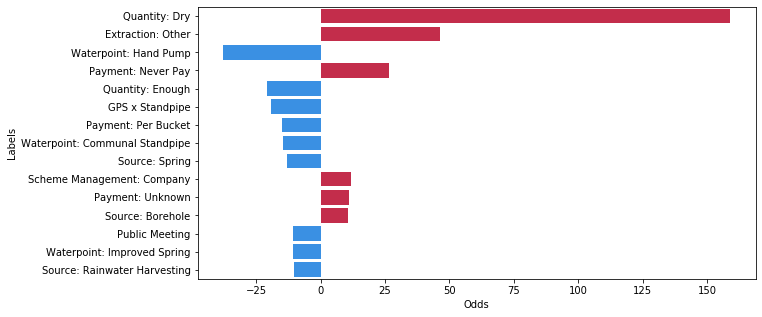

In [370]:
# Plot the top 15 features.
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Odds', y='Labels', data=visual_df.head(15), hue='Sign', palette=['dodgerblue', 'crimson'], dodge=False)
plt.gca().legend().set_title('')
leg = plt.legend()
ax.get_legend().remove()
plt.show()

# Improving Hyperparameters

In [37]:
print('Parameters currently in use:\n')
pprint(logistic_model.get_params())

Parameters currently in use:

{'C': 0.005,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [39]:
# Make a grid of hyperparameters to manipulate.
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'penalty': ['l1', 'l2']}

In [41]:
# Apply gridsearch
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

accuracy : 0.7259075804125651


In [43]:
# Print best score and best hyperparameters

print("accuracy :",logreg_cv.best_score_)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

accuracy : 0.7259075804125651
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}


I've decided not to use these hyperparameters in my final model because the C score and penalty do not reduce the features (which is the point of using logistic regression here) and the accuracy score is not significantly better than my original model.

# Test

In [277]:
X = df_test.drop(columns=['status_group'])
y = df_test['status_group']

In [278]:
#Scale since there are multiple features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [297]:
# Print various metric scores for model on test data.
y_predict = (logistic_model.predict_proba(X)[:, 1] >= .406)

print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y, y_predict), 
                                                     recall_score(y, y_predict)))
print("F1 Score: ", f1_score(y, y_predict))
print("ROC AUC score : ", roc_auc_score(y, logistic_model.predict_proba(X)[:,1]))
    
print("Accuracy score: ", accuracy_score(y, y_predict))

Precision: 0.6602,   Recall: 0.6836
F1 Score:  0.6716615249008374
ROC AUC score :  0.7818069465138316
Accuracy score:  0.7009833433674493
